In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF

from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver
from auto_robot_design.utils.configs import inertial_config_two_link_workspace, get_mesh_builder, inertial_config_two_link_six_trajectories

In [2]:
builder, crag, soft_constrain, reward_manager = inertial_config_two_link_six_trajectories()

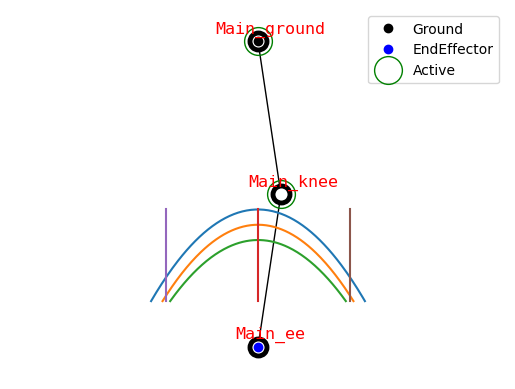

In [ ]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[50:, 0], trajectory[50:, 2])
gm = get_preset_by_index_with_bounds(-1)
values = gm.generate_central_from_mutation_range()
graph = gm.get_graph(values)
draw_joint_point(graph)
plt.show("trajectories.png")

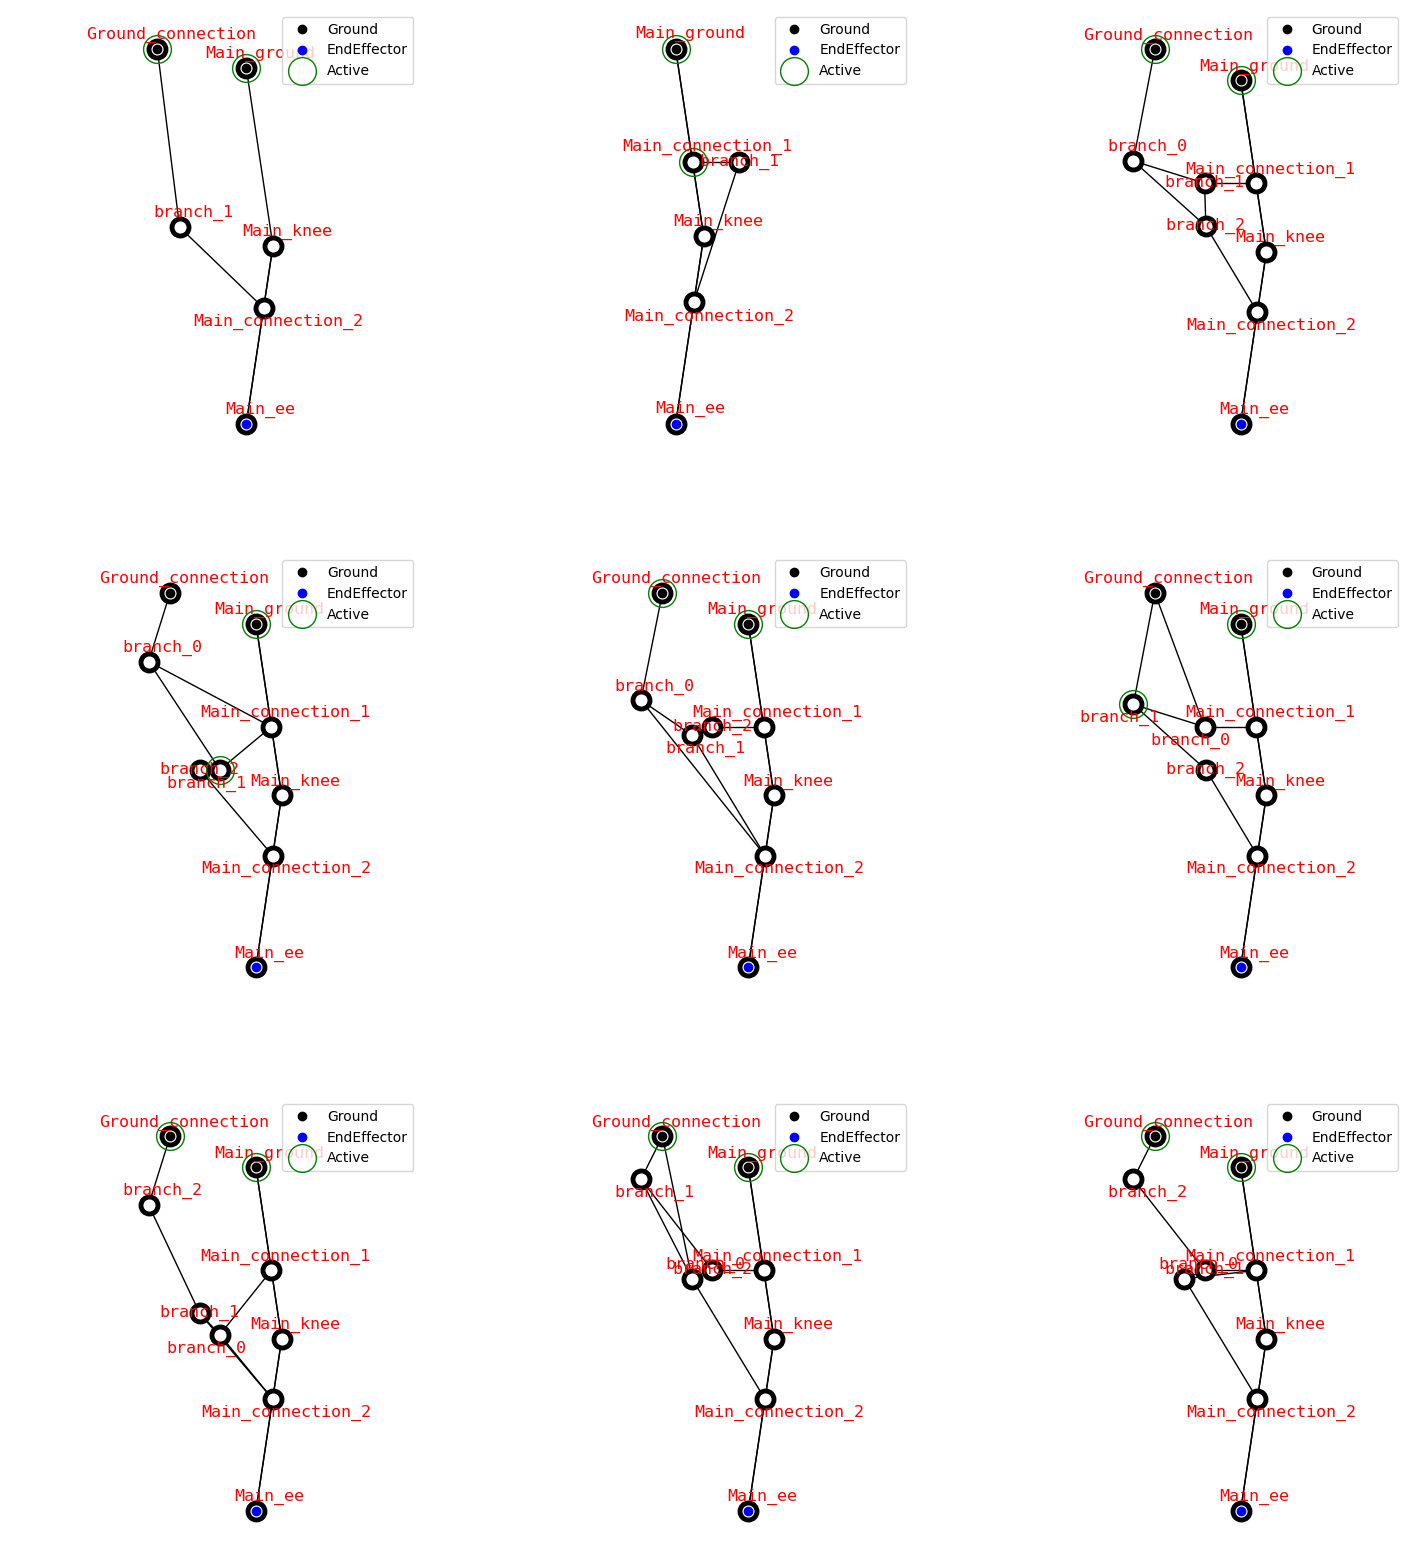

In [ ]:
plt.figure(figsize=(18, 20))
for i in range(9):
    gm = get_preset_by_index_with_bounds(i)
    values = gm.generate_central_from_mutation_range()
    graph = gm.get_graph(values)
    plt.subplot(3, 3, i+1)
    draw_joint_point(graph)

plt.show("topologies.png")

In [5]:
pin.seed(1)
N_PROCESS = 16
population_size = 64
n_generations = 100
for i in range(2,9):
    pool = multiprocessing.Pool(N_PROCESS)
    runner = StarmapParallelization(pool.starmap)
    topology_index = i
    gm = get_preset_by_index_with_bounds(topology_index)
    # activate multiprocessing


    # create the problem for the current optimization
    problem = MultiCriteriaProblem(gm, builder, reward_manager,
                                soft_constrain, elementwise_runner=runner, Actuator=builder.actuator['default'])

    saver = ProblemSaver(problem, f"first_setup\\all_topologies_100gen_64pop\\topology_{topology_index}", True)
    saver.save_nonmutable()
    algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
    optimizer = PymooOptimizer(problem, algorithm, saver)

    res = optimizer.run(
        True, **{
            "seed": 2,
            "termination": ("n_gen", n_generations),
            "verbose": True
        })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       64 |      2 |             - |             -
     2 |      128 |      3 |  0.2948413492 |             f
     3 |      192 |      1 |  0.5158440444 |         ideal
     4 |      256 |      3 |  1.0000000000 |         ideal
     5 |      320 |      4 |  0.8564276283 |         ideal
     6 |      384 |      8 |  0.0622209720 |         ideal
     7 |      448 |     16 |  0.1619170168 |         ideal
     8 |      512 |     20 |  0.0094451314 |         nadir
     9 |      576 |     29 |  0.0294415401 |             f
    10 |      640 |     43 |  0.2977524172 |         ideal
    11 |      704 |     53 |  0.0088357295 |             f
    12 |      768 |     42 |  0.0346272126 |         ideal
    13 |      832 |     47 |  0.0768490532 |         ideal
    14 |      896 |     50 |  0.0060164966 |             f
    15 |      960 |     56 |  0.0090797046 |         nadir
    16 |     1024 |     57 |  0.0069733825 |            

In [7]:
sf = problem.soft_constrain
counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 5)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-1.54213194 -2.30924213] [1.5421520471572876, 2.3094402045345737]
[-1.56048807 -2.00053715] [1.5605171124140422, 2.0006706490463473]
[-1.47257626 -2.7188289 ] [1.472524921099345, 2.717303589470403]
[-1.59284806 -1.59256657] [1.592752496401469, 1.5922723619920471]
[-1.56576832 -1.98802553] [1.5658148129781086, 1.9874622357228013]
[-1.62895258 -1.47726948] [1.6290522813796997, 1.477310158499743]
[-1.13594838 -3.11453255] [1.1355318625768025, 3.1157153765511283]
[-1.46580935 -2.9645246 ] [1.4657727479934692, 2.9647119050753203]


0

In [8]:
from auto_robot_design.motion_planning.trajectory_ik_manager import TrajectoryIKManager
def go_to_point(robot, point):

    to_start_from_init = add_auxilary_points_to_trajectory(np.array([point]).T)
    traj_6d = convert_x_y_to_6d_traj_xz(to_start_from_init[0], to_start_from_init[1])
    
    traj_manager = TrajectoryIKManager()
    traj_manager.register_model(robot.model, robot.constraint_models)
    traj_manager.set_solver(traj_manager.default_name)
    pos, q_arrs, __, reach_array = traj_manager.follow_trajectory(traj_6d, np.zeros(robot.model.nq))
    
    result_q = np.zeros(robot.model.nq)
    if reach_array[-1]:
        result_q = q_arrs[-1]
    else:
        raise Exception("Point is not reachable")
    
    return result_q

In [9]:
F = res.F
xl, xu = problem.bounds()

fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.4, 0.6])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]

graph = gm.get_graph(best_x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

Scale f1: [-1.6289525826772053, -1.135948379834493]
Scale f2: [-3.114532548043282, -1.4772694819750827]


In [10]:
feature_traj_points = fixed_robot.motion_space.rewind_6d_traj(ground_symmetric_step1[50:,:])[[0,49, 99]]

/home/yefim-work/Documents/Be2rLab/CoDesign/auto-robotics-design/auto_robot_design/simulation/trajectory_movments.py:86: RankWarning: Polyfit may be poorly conditioned
  cs_z_by_x = np.polyfit(self.traj[:,0], self.traj[:,1], 3)


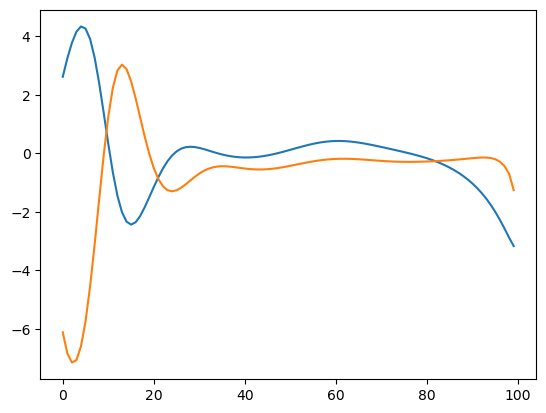

In [11]:
from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements

name_ee = "EE"


point = feature_traj_points[0]

start_q = go_to_point(fixed_robot, point)


test = TrajectoryMovements(feature_traj_points, 1, 0.01, name_ee)
pin.framesForwardKinematics(fixed_robot.model, fixed_robot.data, start_q)

# # q, vq, acc, tau, pos_ee, power
__, __, __, tau_arr, pos_ee, __ = test.simulate(fixed_robot, start_q, False)


# des_traj = np.array(ground_symmetric_step1).T
# plt.plot(pos_ee[:,0], pos_ee[:,2])
# plt.plot(des_traj[:,0], des_traj[:,1], ".")

plt.plot(tau_arr)
plt.show()